# STOCK AND DEMAND OPTIMIZATION

In [6]:
#librdomainaries to import data and maipulation
import math 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
from IPython.display import display
import collections

In [7]:
class State(object):
    def __init__(self, warehouse_num, T, demand_history, t = 0):
        self.warehouse_num = warehouse_num
        self.factory_stock = 0
        self.warehouse_stock = np.repeat(0, warehouse_num)
        self.demand_history = demand_history
        self.T = T
        self.t = t

    def to_array(self):
        return np.concatenate( ([self.factory_stock], self.warehouse_stock, np.hstack(self.demand_history), [self.t]) )

    def stock_levels(self):
        return np.concatenate( ([self.factory_stock], self.warehouse_stock) )

class Action(object):
    def __init__(self, warehouse_num):
        self.production_level = 0
        self.shippings_to_warehouses = np.zeros(warehouse_num)

class SupplyChainEnvironment(object):
    def __init__(self):
        self.T = 30               # episode duration
        self.warehouse_num = 3  
        self.d_max = 4            # maximum demand, units
        self.d_var = 3            # maximum random demand variation, units 
    
        self.unit_price = 500     # unit price in dollars
        self.unit_cost = 20       # unit cost in dollars

        self.storage_capacities = np.fromfunction(lambda j: 10*(j+1), (self.warehouse_num + 1,), dtype=int)

        self.storage_costs = np.fromfunction(lambda j: 2*(j+1), (self.warehouse_num + 1,), dtype=int)           # storage costs at the factory and each warehouse, dollars per unit
        self.transporation_costs = np.fromfunction(lambda j: 5*(j+1), (self.warehouse_num,), dtype=int)       # transportation costs for each warehouse, dollars per unit
        self.penalty_unit_cost = self.unit_price
        
        self.reset()

    def reset(self, demand_history_len = 4):
        self.demand_history = collections.deque(maxlen = demand_history_len)
        for i in range(demand_history_len):
            self.demand_history.append( np.zeros(self.warehouse_num) )
        self.t = 0

    # demand at time t at warehouse j
    def demand(self, j, t):
        return np.round(self.d_max/2 + self.d_max/2*np.sin(2*np.pi*(t + 2*j)/self.T*2) + np.random.randint(0, self.d_var))

    def initial_state(self):
        return State(self.warehouse_num, self.T, list(self.demand_history))

    def step(self, state, action):
        demands = np.fromfunction(lambda j: self.demand(j+1, self.t), (self.warehouse_num,), dtype=int)
    
        # calculating the reward (profit)
        total_revenue = self.unit_price * np.sum(demands)
        total_production_cost = self.unit_cost * action.production_level
        total_storage_cost = np.dot( self.storage_costs, np.maximum(state.stock_levels(), np.zeros(self.warehouse_num + 1)) )
        total_penalty_cost = - self.penalty_unit_cost * ( np.sum( np.minimum(state.warehouse_stock, np.zeros(self.warehouse_num)) )  +  min(state.factory_stock, 0))
        total_transportation_cost = np.dot( self.transporation_costs, action.shippings_to_warehouses )
        reward = total_revenue - total_production_cost - total_storage_cost - total_penalty_cost - total_transportation_cost

        # calculating the next state
        next_state = State(self.warehouse_num, self.T, self.t)
        next_state.factory_stock = min(state.factory_stock + action.production_level - np.sum(action.shippings_to_warehouses), self.storage_capacities[0]) 
        for w in range(self.warehouse_num):
            next_state.warehouse_stock[w] = min(state.warehouse_stock[w] + action.shippings_to_warehouses[w] - demands[w], self.storage_capacities[w+1])    
        next_state.demand_history = list(self.demand_history)

        self.t += 1
        self.demand_history.append(demands)

        return next_state, reward, self.t == self.T - 1

In [8]:
env = SupplyChainEnvironment()
demands = np.fromfunction(lambda j, t: env.demand(j, t), (env.warehouse_num, env.T), dtype=int)

# (S,Q) - Policy

In [9]:
#(s, Q)-policy as a baseline 

class SQPolicy(object):
    def __init__(self, factory_safety_stock, factory_reorder_amount, safety_stock, reorder_amount):
        self.factory_safety_stock = factory_safety_stock
        self.factory_reorder_amount = factory_reorder_amount
        self.safety_stock = safety_stock
        self.reorder_amount = reorder_amount

    def select_action(self, state):
        action = Action(state.warehouse_num)
        for w in range(state.warehouse_num):
            if state.warehouse_stock[w] < self.safety_stock[w]:
                action.shippings_to_warehouses[w] = self.reorder_amount[w]
    
        if state.factory_stock - np.sum(action.shippings_to_warehouses) < self.factory_safety_stock: 
            action.production_level = self.factory_reorder_amount
        else: 
            action.production_level = 0
        return action
    
def simulate_episode(env, policy):
    state = env.initial_state()
    transitions = []
    for t in range(env.T):
        action = policy.select_action(state)
        state, reward, _ = env.step(state, action)
        transitions.append([state, action, reward])
    return transitions

# basic policy evaluation process 
def simulate(env, policy, num_episodes):
    returns_trace = []
    for episode in range(num_episodes):
        env.reset()
        returns_trace.append( sum(np.array(simulate_episode(env, policy)).T[2]) )
    return returns_trace


In [10]:
from sklearn.model_selection import ParameterGrid
configuration = []
p_grid1 = [5, 10, 15]
p_grid2 = [5, 10, 15]
param_grid = {
    'factory_s': p_grid1, 
    'factory_Q': p_grid1,
    'w1_s': p_grid2,
    'w2_s': p_grid2,
    'w3_s': p_grid2,
    'w1_Q': p_grid2,
    'w2_Q': p_grid2,
    'w3_Q': p_grid2,
    }

env = SupplyChainEnvironment()
grid = ParameterGrid(param_grid)
i = 0
best_return = float('-inf')
for p in grid:
    policy = SQPolicy(
        p['factory_s'], p['factory_Q'],
        [ p['w1_s'], p['w2_s'], p['w3_s'], ],
        [ p['w1_Q'], p['w2_Q'], p['w3_Q'], ]
    )
    m_return = np.mean(simulate(env, policy, num_episodes = 10))
    if m_return > best_return:
        best_return = m_return
        best_params = p

    if i % 100 == 0:
        configuration.append(best_return)
    i += 1

Text(0.5, 1.0, 'Best returns')

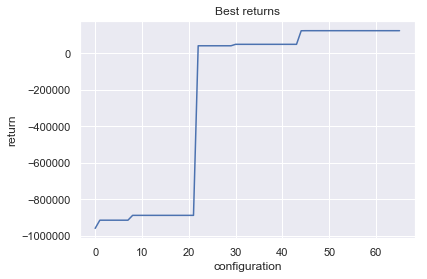

In [11]:
plt.plot(configuration)
plt.xlabel("configuration")
plt.ylabel("return")
plt.title("Best returns")

Reward: mean 121503.55, standard deviation 7032.318682163089


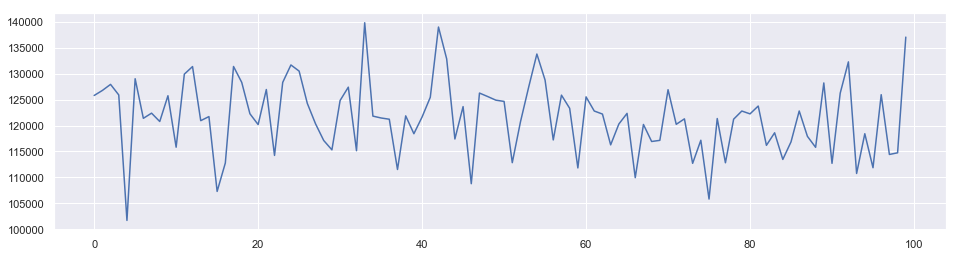

In [12]:
env = SupplyChainEnvironment()
policy_sQ = SQPolicy(0.0, 20.0, [5, 5, 5], [5, 5, 10])
return_trace = simulate(env, policy_sQ, num_episodes = 100)
plt.figure(figsize=(16, 4))
plt.plot(range(len(return_trace)), return_trace)
print(f"Reward: mean {np.mean(return_trace)}, standard deviation {np.std(return_trace)}")

Return is 120166.0


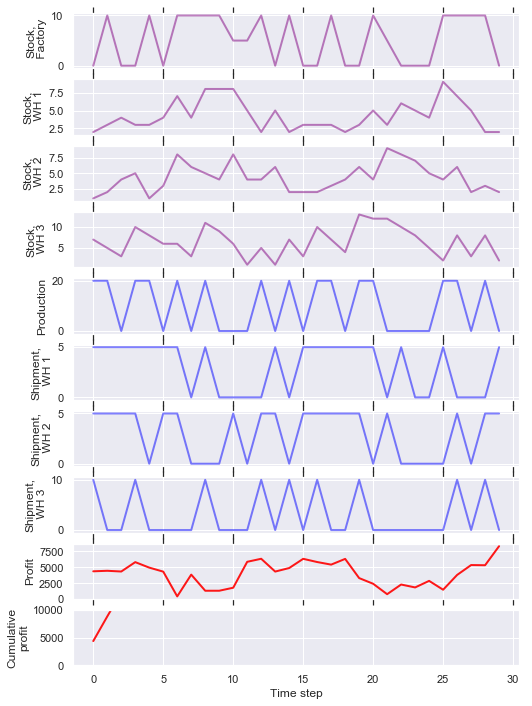

In [20]:
def prepare_metric_plot(plots_n, n, ylabel):
    plt.subplot(plots_n, 1, n)
    plt.ylabel(ylabel)
    plt.tick_params(axis='x', which='both', bottom=True, top=True, labelbottom=False)
def visualize_transitions(transitions):
    state_trace, action_trace, reward_trace = (transitions.T[0], transitions.T[1], transitions.T[2])
    plots_n = 10
    mpl.rcParams['lines.linewidth'] = 2    
    print(f"Return is {sum(reward_trace)}")

    fig = plt.figure(figsize=(8, 12))
    prepare_metric_plot(plots_n, 1, "Stock,\n Factory")
    plt.plot(range(env.T), list(map(lambda s: s.factory_stock, state_trace)), c='purple', alpha=0.5)

    for w in range(env.warehouse_num):
        prepare_metric_plot(plots_n, 2 + w, f"Stock,\n WH {w+1}")
        plt.plot(range(env.T), list(map(lambda s: s.warehouse_stock[w], state_trace)), c='purple', alpha=0.5)
    
    prepare_metric_plot(plots_n, 5, "Production")
    plt.plot(range(env.T), list(map(lambda a: a.production_level, action_trace)), c='blue', alpha=0.5)

    for w in range(env.warehouse_num):
        prepare_metric_plot(plots_n, 6 + w, f"Shipment,\n WH {w+1}")
        plt.plot(range(env.T), list(map(lambda a: a.shippings_to_warehouses[w], action_trace)), c='blue', alpha=0.5)
    
    prepare_metric_plot(plots_n, 9, "Profit")
    plt.plot(range(env.T), reward_trace, c='red', alpha=0.9, linewidth=2)

    plt.subplot(plots_n, 1, 10)
    plt.ylabel("Cumulative\nprofit")
    plt.ylim(0, 10000)
    plt.plot(range(env.T), np.cumsum(reward_trace), c='red', alpha=0.9, linewidth=2)
    plt.xlabel("Time step")
    
env = SupplyChainEnvironment()
transitions_sQ = simulate_episode(env, policy_sQ)
visualize_transitions(np.array(transitions_sQ))

# Price Optimization

In [14]:
# Environment simulator
def plus(x):
  return 0 if x < 0 else x

def minus(x):
  return 0 if x > 0 else -x

def shock(x):
  return np.sqrt(x)

# Demand at time step t for current price p_t and previous price p_t_1
def q_t(p_t, p_t_1, q_0, k, a, b):
  return plus(q_0 - k*p_t - a*shock(plus(p_t - p_t_1)) + b*shock(minus(p_t - p_t_1)))

# Profit at time step t
def profit_t(p_t, p_t_1, q_0, k, a, b, unit_cost):
  return q_t(p_t, p_t_1, q_0, k, a, b)*(p_t - unit_cost) 

# Total profit for price vector p over len(p) time steps
def profit_total(p, unit_cost, q_0, k, a, b):
  return profit_t(p[0], p[0], q_0, k, 0, 0, unit_cost) + sum(map(lambda t: profit_t(p[t], p[t-1], q_0, k, a, b, unit_cost), range(len(p))))

## Environment parameters
T = 20
price_max = 500
price_step = 10
q_0 = 5000
k = 20
unit_cost = 20
a_q = 300
b_q = 100

## Partial bindings for readability
def profit_t_response(p_t, p_t_1):
  return profit_t(p_t, p_t_1, q_0, k, a_q, b_q, unit_cost)

def profit_response(p):
  return profit_total(p, unit_cost, q_0, k, a_q, b_q)
price_grid = np.arange(price_step, price_max, price_step)
price_change_grid = np.arange(0.5, 2.0, 0.1)
profit_map = np.zeros( (len(price_grid), len(price_change_grid)) )

In [21]:
#visualizations
def plot_return_trace(returns, smoothing_window=10, range_std=2):
  plt.figure(figsize=(16, 5))
  plt.xlabel("Episode")
  plt.ylabel("Return ($)")
  returns_df = pd.Series(returns)
  ma = returns_df.rolling(window=smoothing_window).mean()
  plt.plot(ma)
  

# DQN - Algorithm

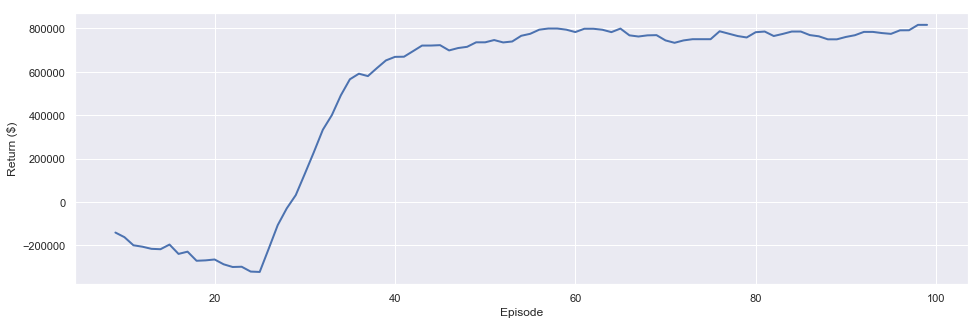

In [22]:
#libraries for DQN algorithm
from collections import namedtuple
from itertools import count
import torch.nn.functional as F
import random
import torch
import torch.nn as nn
import torch.optim as optim
from IPython.display import clear_output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

class PolicyNetworkDQN(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=128):
      super(PolicyNetworkDQN, self).__init__()
      layers = [
              nn.Linear(state_size, hidden_size),
              nn.ReLU(),
              nn.Linear(hidden_size, hidden_size),
              nn.ReLU(),
              nn.Linear(hidden_size, hidden_size),
              nn.ReLU(),
              nn.Linear(hidden_size, action_size)
      ]
      self.model = nn.Sequential(*layers)

    def forward(self, x):
      q_values = self.model(x)
      return q_values  

class EpsGreedyPolicy(object):
  def __init__(self, eps_start = 0.9, eps_end = 0.05, eps_decay = 400):
    self.eps_start = eps_start
    self.eps_end = eps_end
    self.eps_decay = eps_decay
    self.steps_done = 0

  def select_action(self, q_values):
    sample = random.random()
    eps_threshold = self.eps_end + (self.eps_start - self.eps_end) * math.exp(-1. * self.steps_done / self.eps_decay)
    self.steps_done += 1
    if sample > eps_threshold:
        return np.argmax(q_values)
    else:
        return random.randrange(len(q_values))

GAMMA = 1.00
TARGET_UPDATE = 20
BATCH_SIZE = 512

def update_model(memory, policy_net, target_net):
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.stack([s for s in batch.next_state if s is not None])

    state_batch = torch.stack(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.stack(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()

    # Compute the expected Q values
    expected_state_action_values = reward_batch[:, 0] + (GAMMA * next_state_values)  

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

def env_intial_state():
  return np.repeat(0, 2*T)

def env_step(t, state, action):
  next_state = np.repeat(0, len(state))
  next_state[0] = price_grid[action]
  next_state[1:T] = state[0:T-1]
  next_state[T+t] = 1
  reward = profit_t_response(next_state[0], next_state[1])
  return next_state, reward

def to_tensor(x):
  return torch.from_numpy(np.array(x).astype(np.float32))

def to_tensor_long(x):
  return torch.tensor([[x]], device=device, dtype=torch.long)

policy_net = PolicyNetworkDQN(2*T, len(p_grid1)).to(device)
target_net = PolicyNetworkDQN(2*T, len(p_grid2)).to(device)
optimizer = optim.AdamW(policy_net.parameters(), lr = 0.005)
policy = EpsGreedyPolicy()
memory = ReplayMemory(10000)

target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

num_episodes = 100
return_trace = []
p_trace = []
for i_episode in range(num_episodes):
    state = env_intial_state()
    reward_trace = []
    p = []
    for t in range(T):
        # Select and perform an action
        with torch.no_grad():
          q_values = policy_net(to_tensor(state))
        action = policy.select_action(q_values.detach().numpy())

        next_state, reward = env_step(t, state, action)

        # Store the transition in memory
        memory.push(to_tensor(state), 
                    to_tensor_long(action), 
                    to_tensor(next_state) if t != T - 1 else None, 
                    to_tensor([reward]))

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        update_model(memory, policy_net, target_net)

        reward_trace.append(reward)
        p.append(price_grid[action])

    return_trace.append(sum(reward_trace))
    p_trace.append(p)

    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

plot_return_trace(return_trace)